# AD99 w/ spectrum of wavenumber
Instead of k ~ $2\pi/300km$, use a spectrum of k's from 300km down to 10k with $d\lambda \approx 5km$ 

In [7]:
def test(x):
    match x:
        case float() as f:
            print(f"Matched float: {f}")
        case 'never':
            print("Matched 'never'")
        case 'always':
            print("Matched 'always'")
        case _:
            print("Default")

test(10)

Default


In [ ]:
import numpy as np
from ad99py import AlexanderDunkerton1999,R_DRY,GRAV,C_P

BASE = 300e3 # 300 km grid cell 

wavelengths = 300e3/np.arange(1,10)
ad99s  = [AlexanderDunkerton1999(damp_top=True,base_wavelength=lambda_,Fs0=4e-3/len(wavelengths)) for lambda_ in wavelengths]



In [2]:
ad99s

[AlexanderDunkerton1999(Bm=0.4,cw=35,Fs0=0.00044444444444444447,height=9000.0, λ=300000.0, damp_top=True),
 AlexanderDunkerton1999(Bm=0.4,cw=35,Fs0=0.00044444444444444447,height=9000.0, λ=150000.0, damp_top=True),
 AlexanderDunkerton1999(Bm=0.4,cw=35,Fs0=0.00044444444444444447,height=9000.0, λ=100000.0, damp_top=True),
 AlexanderDunkerton1999(Bm=0.4,cw=35,Fs0=0.00044444444444444447,height=9000.0, λ=75000.0, damp_top=True),
 AlexanderDunkerton1999(Bm=0.4,cw=35,Fs0=0.00044444444444444447,height=9000.0, λ=60000.0, damp_top=True),
 AlexanderDunkerton1999(Bm=0.4,cw=35,Fs0=0.00044444444444444447,height=9000.0, λ=50000.0, damp_top=True),
 AlexanderDunkerton1999(Bm=0.4,cw=35,Fs0=0.00044444444444444447,height=9000.0, λ=42857.142857142855, damp_top=True),
 AlexanderDunkerton1999(Bm=0.4,cw=35,Fs0=0.00044444444444444447,height=9000.0, λ=37500.0, damp_top=True),
 AlexanderDunkerton1999(Bm=0.4,cw=35,Fs0=0.00044444444444444447,height=9000.0, λ=33333.333333333336, damp_top=True)]

## load Loon

In [26]:
from glob import iglob 
import os
LOON_GW_DATA_PATH = '/Users/robcking/PhD/loon_GW_mom_flux'
u_flux_ptv = []
u_flux_ntv = []
for f in iglob(os.path.join(LOON_GW_DATA_PATH,'*flux.npy')):
    flux = np.load(f)
    u_flux_ntv.append(flux[0])
    u_flux_ptv.append(flux[1])
    v_flux_ntv = flux[2]    
    v_flux_ptv = flux[3]

loon_ntv_u = np.concatenate(u_flux_ntv)
loon_ptv_u = np.concatenate(u_flux_ptv)
loon_abs_u = np.concatenate([np.abs(loon_ntv_u),np.abs(loon_ptv_u)])

## load MiMA

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
## Load in MiMA data
ds = xr.open_dataset('data/atmos_daily_flag0.nc')


In [3]:
ds_mask_trop = xr.open_dataset('data/loon_masks.nc')

ds_mask_trop['lon'] = (ds_mask_trop.lon + 360) % 360 
ds_mask_trop = ds_mask_trop.sortby('lon')

interp_mask = ds_mask_trop.interp(lat=ds.lat,lon=ds.lon,method='nearest').astype(bool)
total_mask = sum(interp_mask[d] for d in interp_mask.data_vars)


In [6]:
ocean_expac = ds.where(total_mask).stack(points = ['lat','lon'])
ocean_expac = ocean_expac.dropna('points',how='all')
ocean_expac = ocean_expac[['ucomp','temp','vcomp','height','gwfu_cgwd','gwfv_cgwd']]
ocean_expac = ocean_expac.transpose('time','points','pfull')

In [7]:
us = ocean_expac.ucomp.values[...,::-1]
zs = ocean_expac.height.values[...,::-1]
temps= ocean_expac.temp.values[...,::-1]

gwfu = ocean_expac.gwfu_cgwd.values[...,::-1]
gwfv = ocean_expac.gwfv_cgwd.values[...,::-1]
pfull = ocean_expac.pfull.values[...,::-1]

In [8]:
dTdz = np.gradient(temps,axis=-1)/np.gradient(zs,axis=-1)
Ns2 = GRAV/temps*(dTdz + GRAV/C_P) 
bflim = 1e-4 
Ns2 = xr.where(Ns2 < bflim**2,bflim**2,Ns2)
Ns = np.sqrt(Ns2)
rho = (100*pfull.reshape((1,1,-1)))/(R_DRY*temps)

In [9]:
from joblib import Parallel, delayed
from tqdm.notebook import tqdm 
gwd = np.zeros_like(us)
uw_ptv = np.zeros_like(us)
uw_ntv = np.zeros_like(us)

def get_ad99(i,j,ad99s):
    gwd = np.zeros_like(us[i,j])
    uw_ptv = np.zeros_like(us[i,j])
    uw_ntv = np.zeros_like(us[i,j])
    for ad99 in ad99s:
        gwd += ad99.gwd(us[i,j],Ns[i,j],zs[i,j],rho[i,j])
        uw_ptv += ad99.gwd_momentum_flux_ptv(gwd,zs[i,j],rho[i,j])
        uw_ntv += ad99.gwd_momentum_flux_ntv(gwd,zs[i,j],rho[i,j])
    return i,j,gwd,uw_ptv,uw_ntv

results = Parallel(n_jobs=-1)(delayed(get_ad99)(i,j,ad99s) for i in range(us.shape[0]) for j in range(us.shape[1]))

for i,j,gwd_val,uw_ptv_val,uw_ntv_val in results:
    gwd[i,j] = gwd_val
    uw_ptv[i,j] = uw_ptv_val
    uw_ntv[i,j] = uw_ntv_val

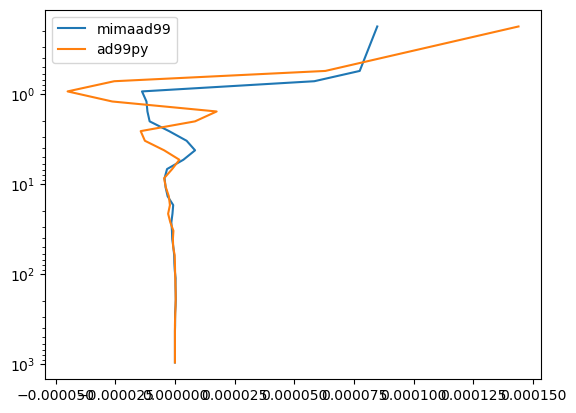

In [11]:
import matplotlib.pyplot as plt 
point = 20
plt.plot(gwfu[0,point],pfull,label="mimaad99")
plt.plot(gwd[0,point],pfull,label="ad99py")
plt.yscale('log')
plt.gca().invert_yaxis()
plt.legend()

Plot at a given level

In [21]:
level = 10#hPa
i_level = np.argmin(np.abs(pfull-level))

uw_ptv_level = uw_ptv[...,i_level].ravel()
uw_ptv_level = uw_ptv_level[uw_ptv_level > 0]

(-3.0, 3.0)

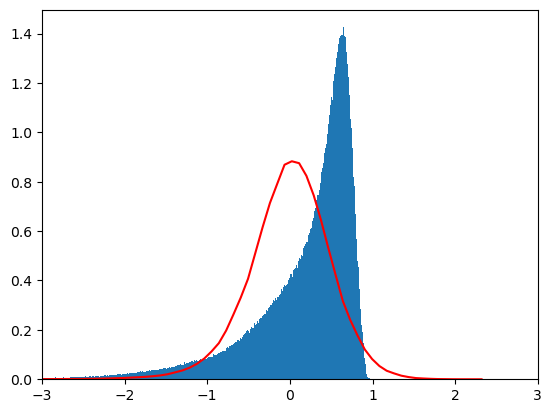

In [28]:
plt.hist(np.log10(1000*uw_ptv_level),bins=1000,density=True)

log_loon_ptv_u = np.log10(loon_ptv_u[loon_ptv_u > 0])
loon_bin_heights,loon_bin_edges = np.histogram(log_loon_ptv_u[~np.isnan(log_loon_ptv_u)],bins=100,density=True)
bin_centers = 0.5*(loon_bin_edges[1:] + loon_bin_edges[:-1])
plt.plot(bin_centers,loon_bin_heights,color='red')
plt.xlim(-3,3)


(0.0, 50.0)

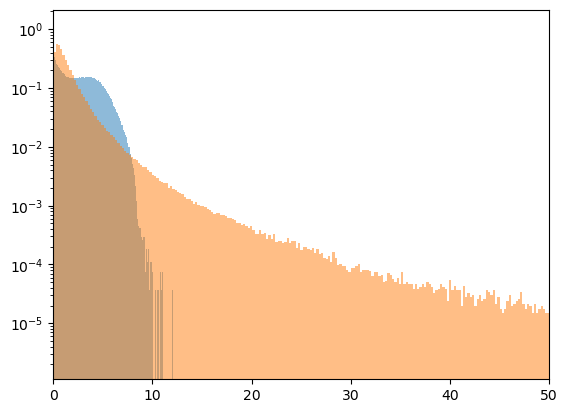

In [33]:
plt.hist(1000*uw_ptv_level,bins=1000,density=True,alpha=0.5)
plt.hist(loon_ptv_u[loon_ptv_u > 0],bins=1000,density=True,alpha=0.5)
plt.yscale("log")
plt.xlim(0,50)